In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [2]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [3]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [4]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

## Dynamics & stress-response characterization

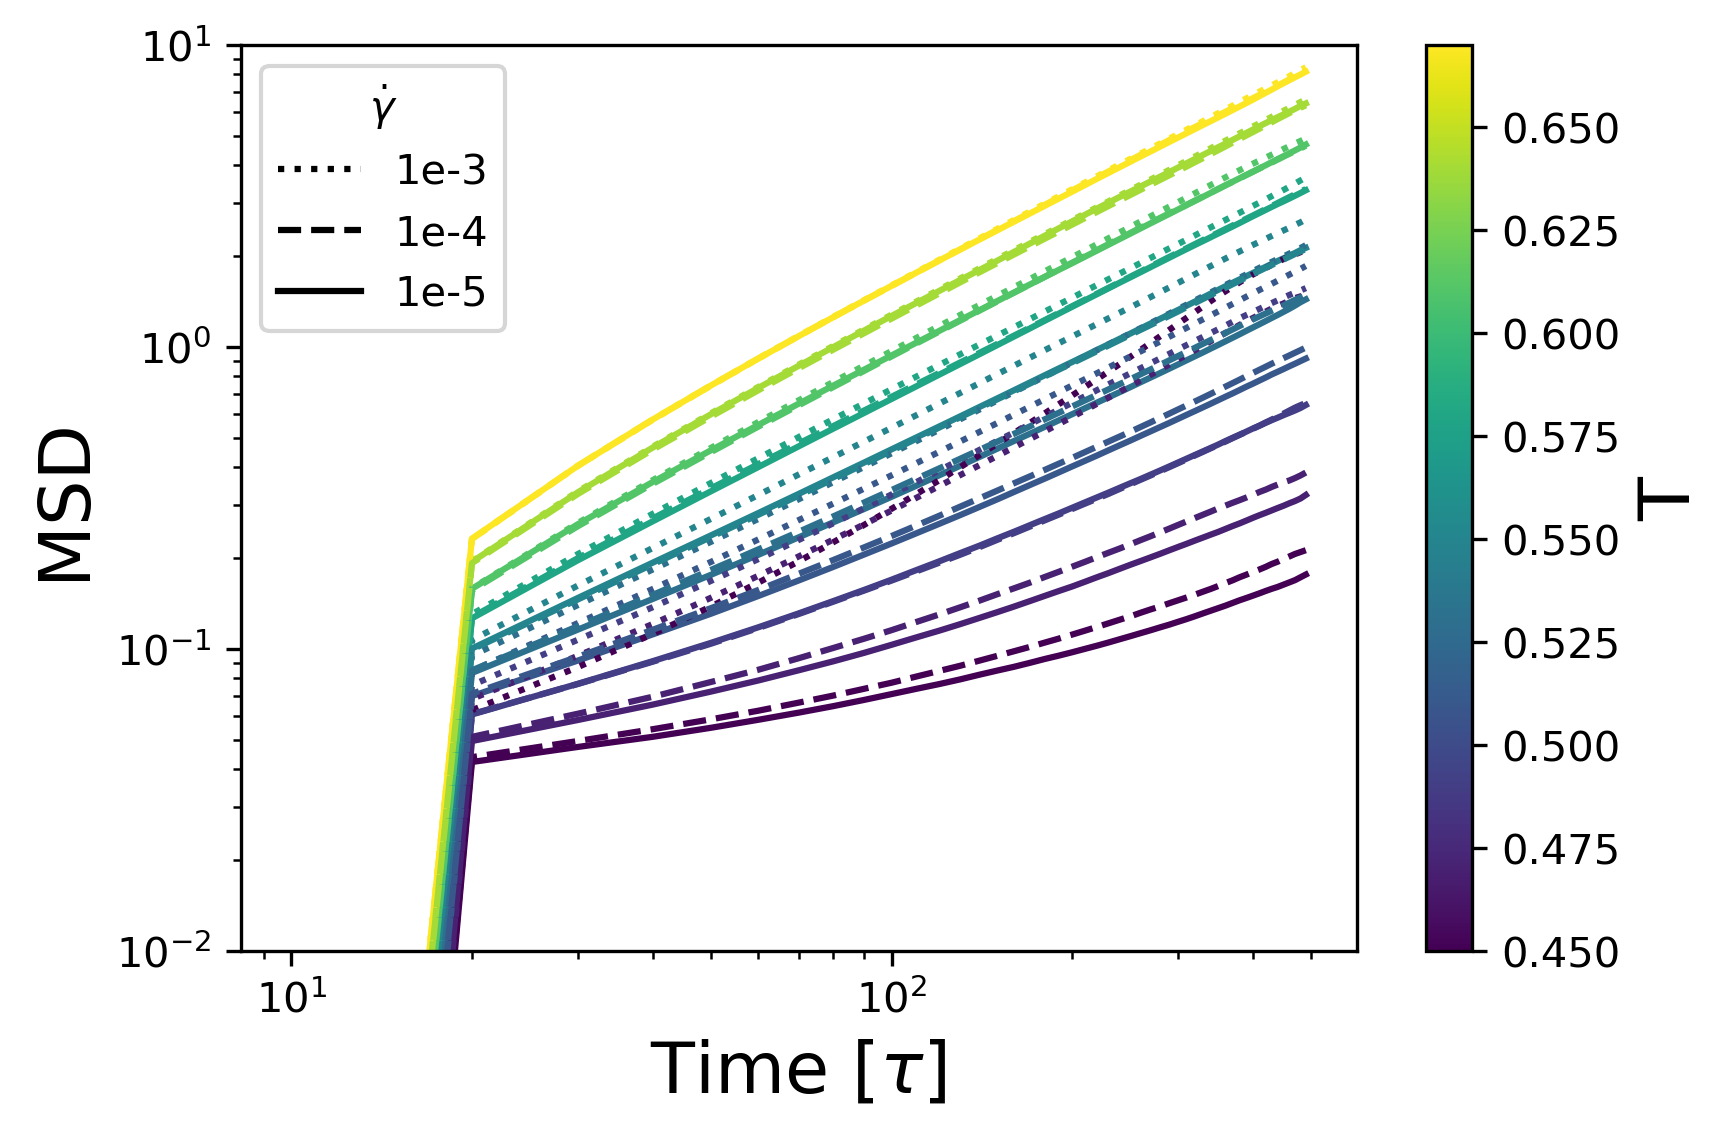

In [18]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj[1:]:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        msd.compute(pos, reset=True)
        plt.plot(time, msd.msd, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel("MSD")
plt.xlabel(r"Time [$\tau$]")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}$")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-2, 1e1)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

In [11]:
def sisf(pos, k=7.14):

    term = k*np.linalg.norm(pos - pos[0], axis=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.mean(np.nan_to_num(np.sin(term)/term, nan=1.0), axis=1)

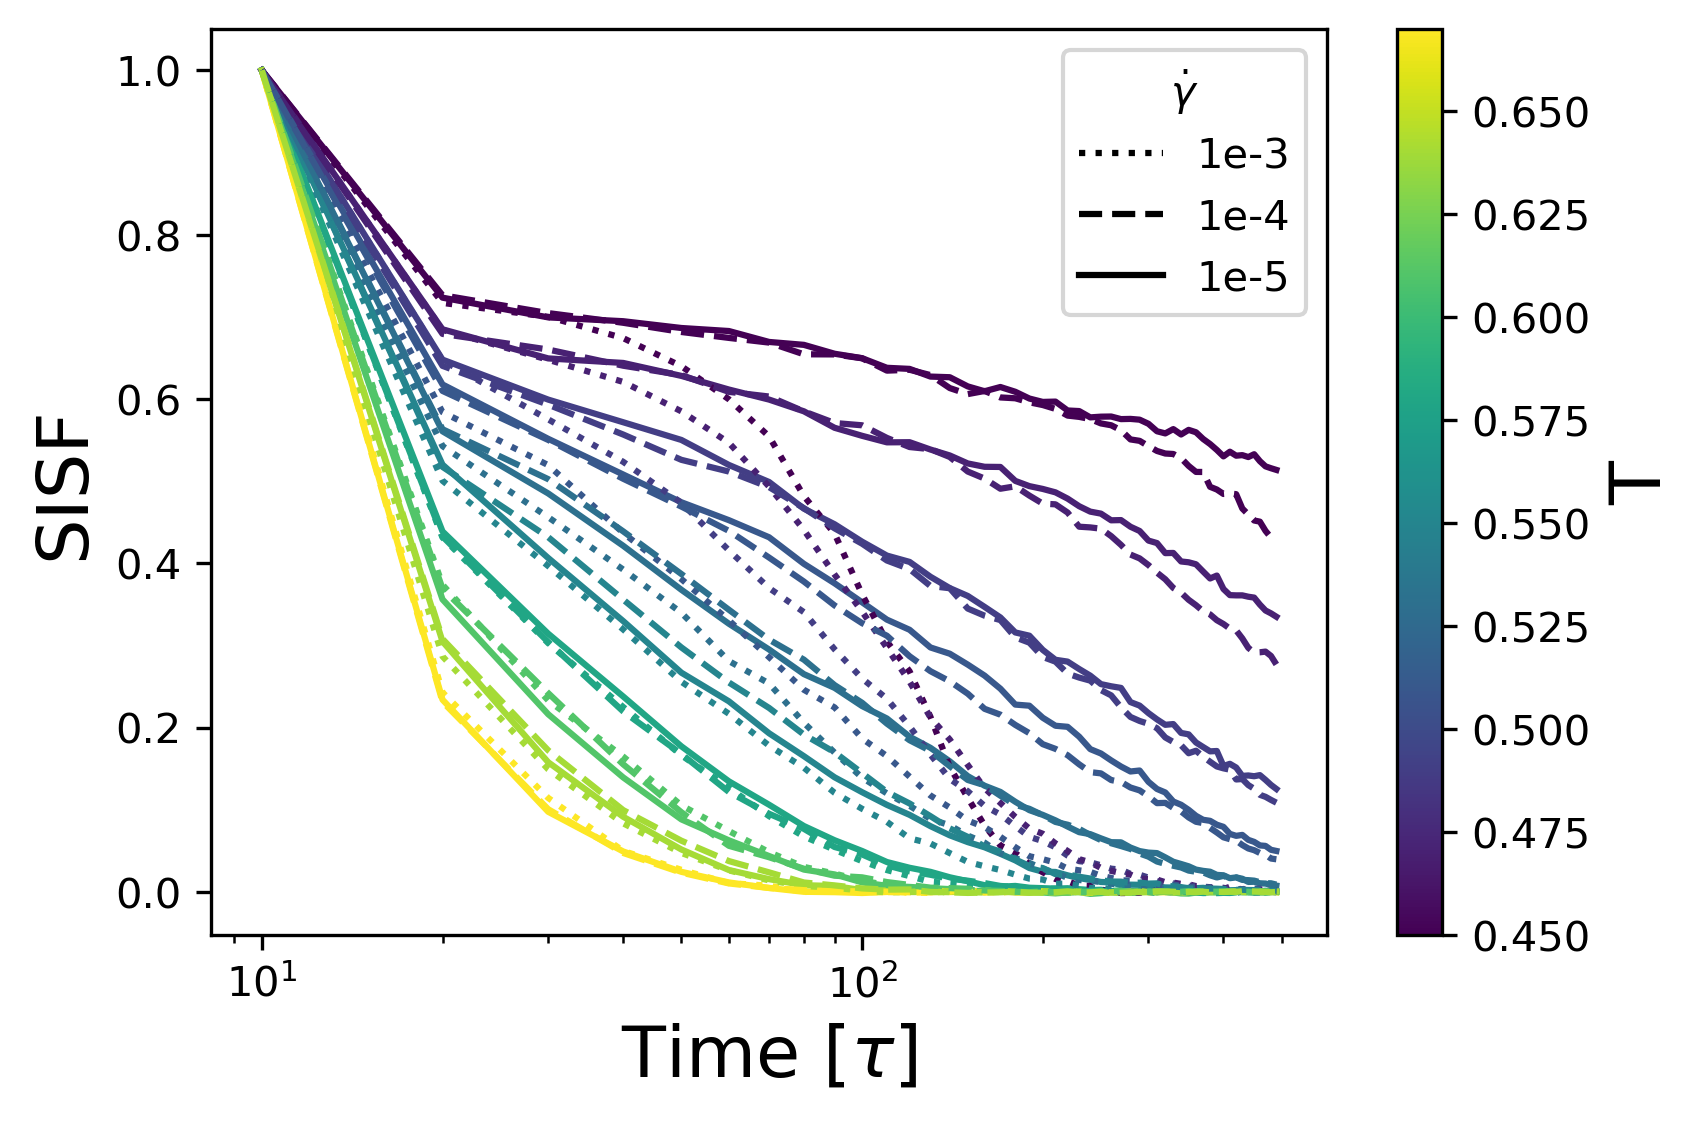

In [15]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj[1:]:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        data = sisf(pos)
        plt.plot(time, data, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel("SISF")
plt.xlabel(r"Time [$\tau$]")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}$")
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

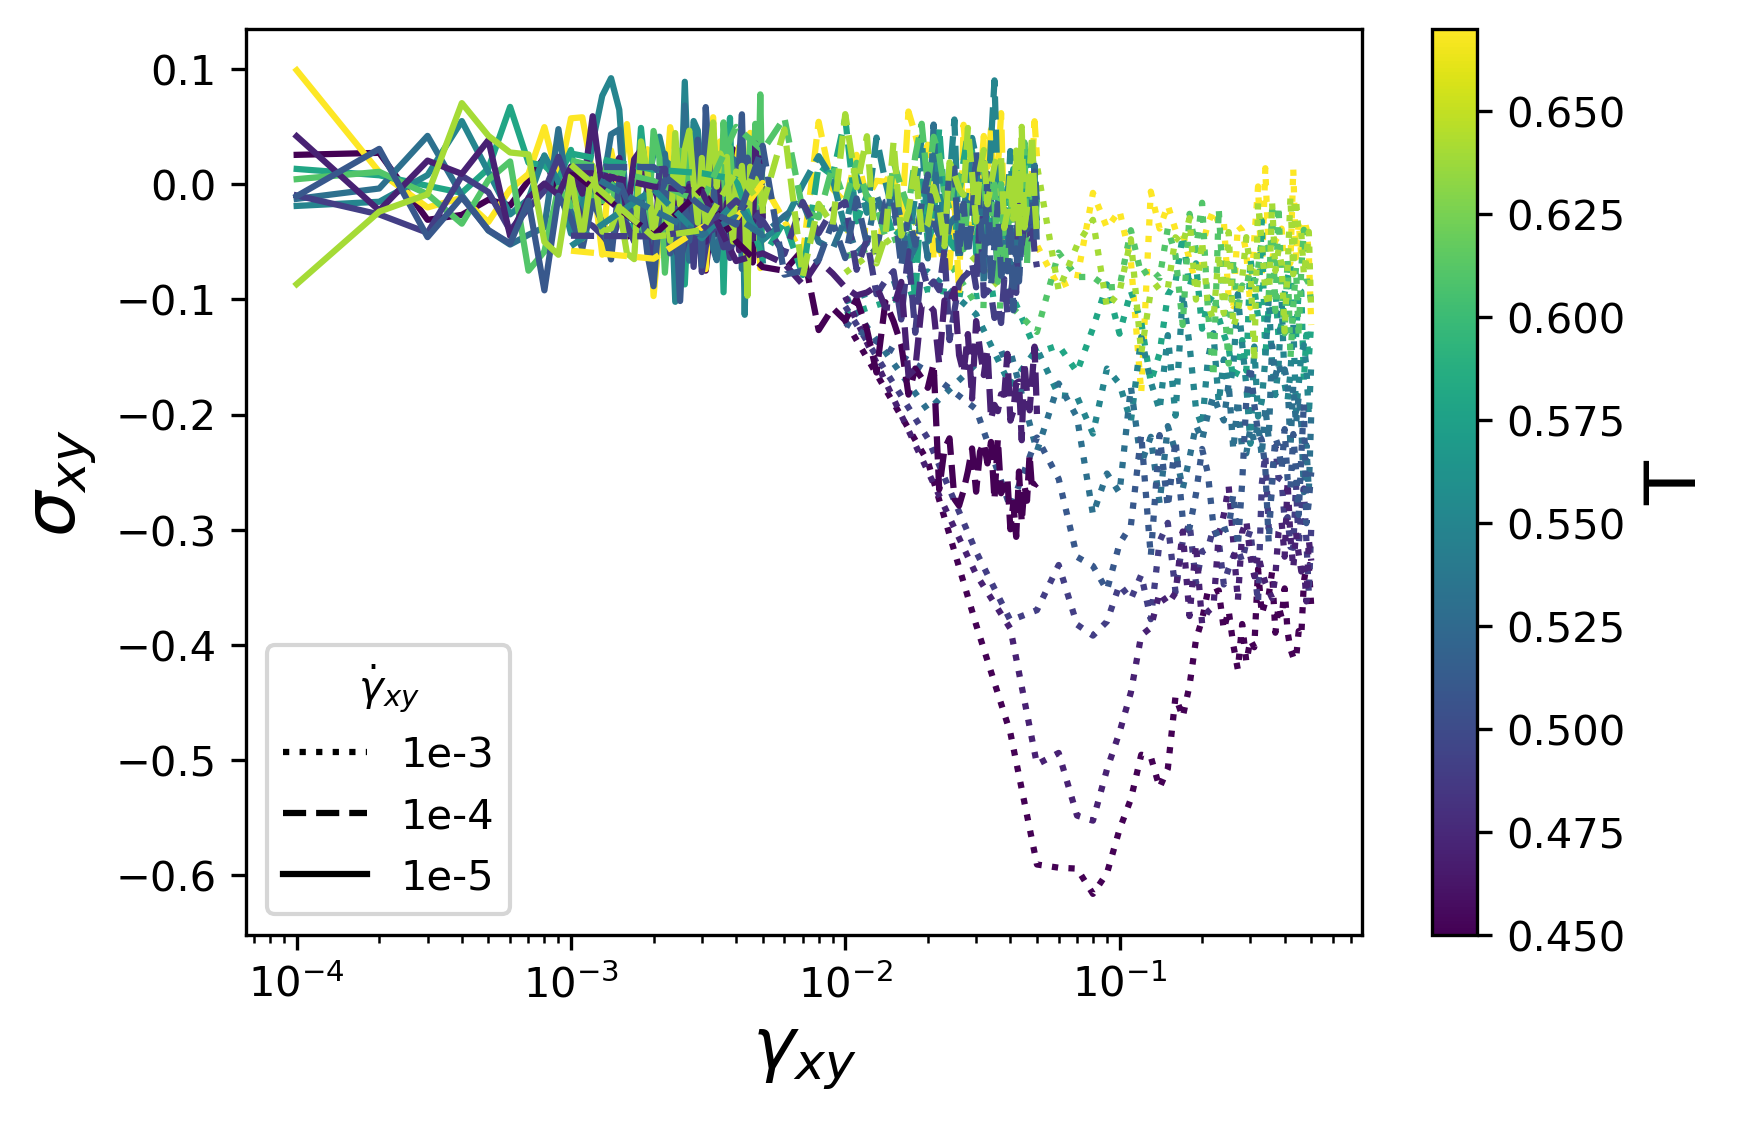

In [26]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        # step0 = traj[0].configuration.step
        # box0 = freud.box.Box.from_box(traj[0].configuration.box)
        # pos0 = box0.make_fractional(traj[0].particles.position)
        # unit_box = freud.box.Box.cube(1)
        # cube_box = freud.box.Box.cube(box0.Lx)
        # prev = pos0
        # image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            pos.append(frame.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1])
            time.append(frame.log["box/xy"][0])
            # box = freud.box.Box.from_box(frame.configuration.box)
            # new = box.make_fractional(frame.particles.position)
            # image += unit_box.get_images(new - prev)
            # x = box.unwrap(new, image)
            # x -= box.make_absolute(pos0)
            # pos.append(x)
            # time.append((frame.configuration.step - step0)*dt)
            # prev = new
        # data = sisf(pos)
        plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel(r"$\sigma_{xy}$")
plt.xlabel(r"$\gamma_{xy}$")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}_{xy}$")
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

## Analysis of shear runs

Let's get the $D^2_{min}$ computation going, and compare that to affinely transformed $p_{hop}$

In [ ]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/analysis-traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        # step0 = traj[0].configuration.step
        # box0 = freud.box.Box.from_box(traj[0].configuration.box)
        # pos0 = box0.make_fractional(traj[0].particles.position)
        # unit_box = freud.box.Box.cube(1)
        # cube_box = freud.box.Box.cube(box0.Lx)
        # prev = pos0
        # image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            pos.append(frame.log["md/compute/ThermodynamicQuantities/pressure_tensor"][1])
            time.append(frame.log["box/xy"][0])
            # box = freud.box.Box.from_box(frame.configuration.box)
            # new = box.make_fractional(frame.particles.position)
            # image += unit_box.get_images(new - prev)
            # x = box.unwrap(new, image)
            # x -= box.make_absolute(pos0)
            # pos.append(x)
            # time.append((frame.configuration.step - step0)*dt)
            # prev = new
        # data = sisf(pos)
        plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel(r"$\sigma_{xy}$")
plt.xlabel(r"$\gamma_{xy}$")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}_{xy}$")
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

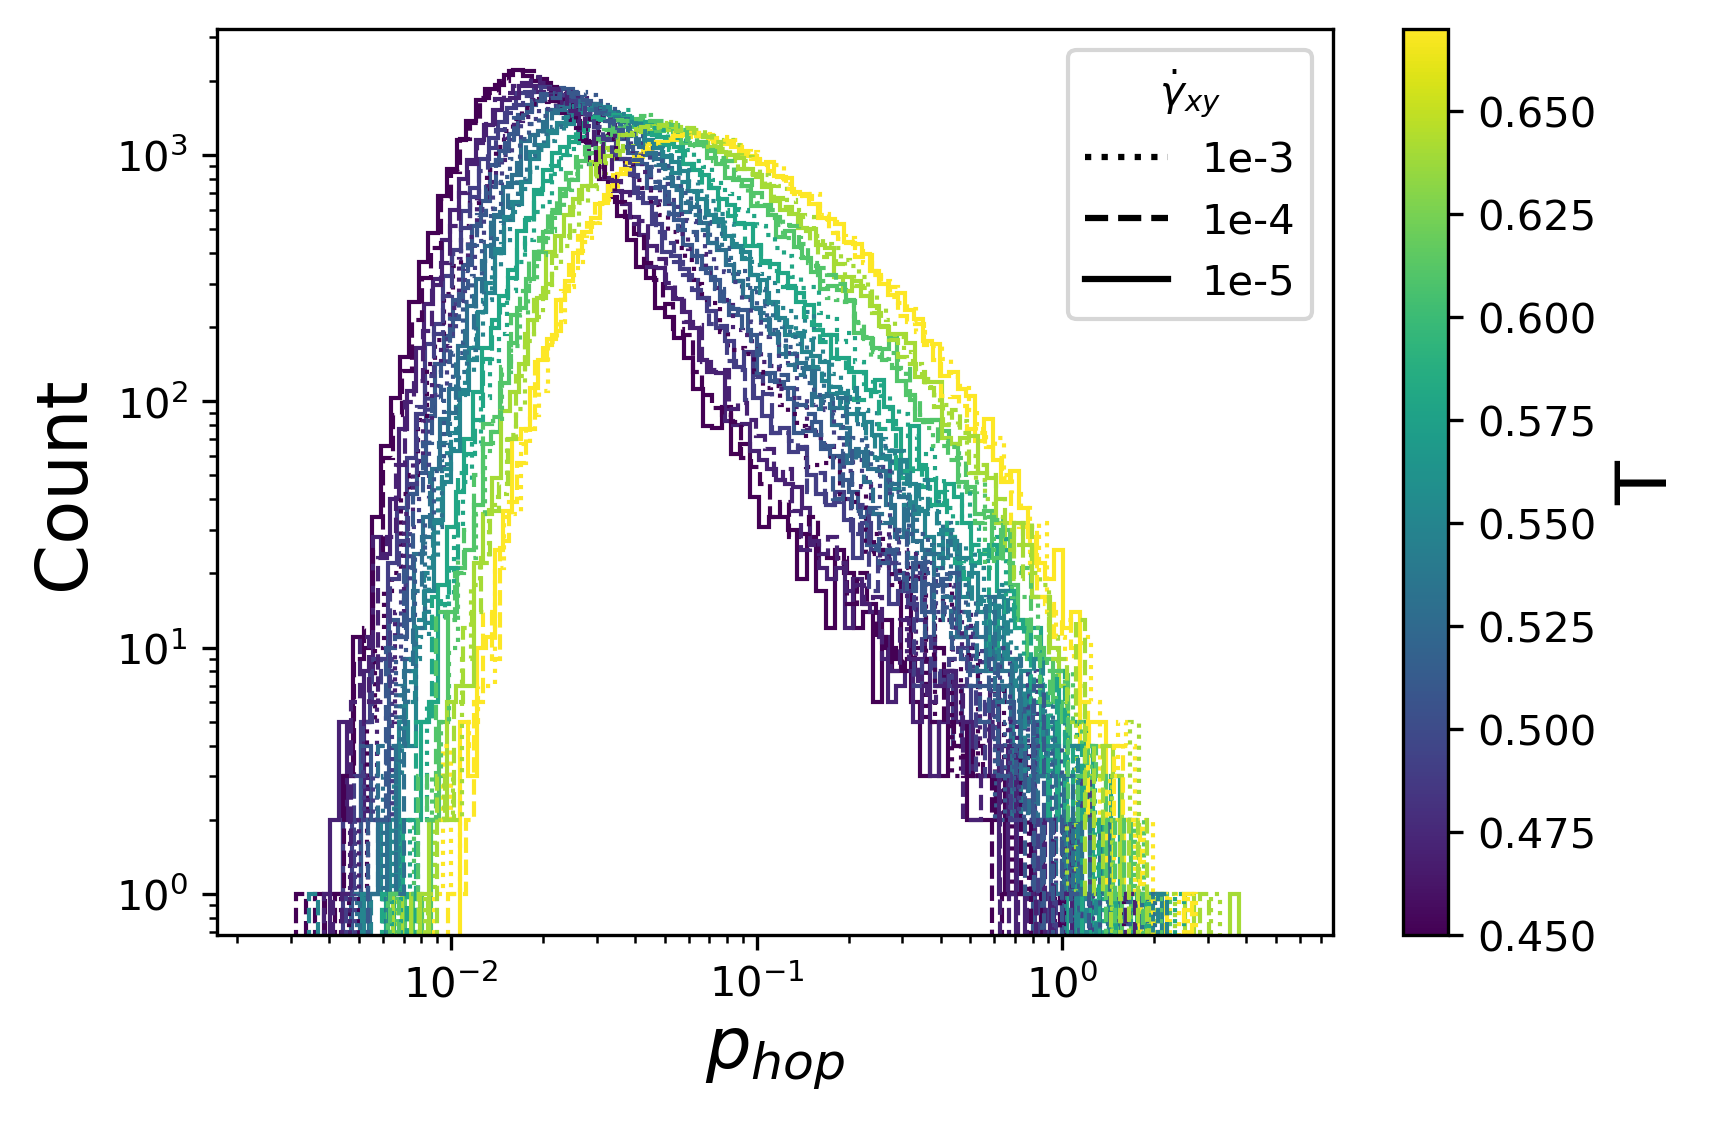

In [19]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/analysis_traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/analysis_traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        phop = schmeud_dynamics.p_hop(np.array(pos), 11)
        # plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])
        plt.hist(phop[0], bins=np.geomspace(np.min(phop), np.max(phop), 100), histtype="step", color=cmap(norm(temp)), linestyle=ls[rate])
        # break
    break

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.xlabel(r'$p_{hop}$')
plt.ylabel("Count")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}_{xy}$")
plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

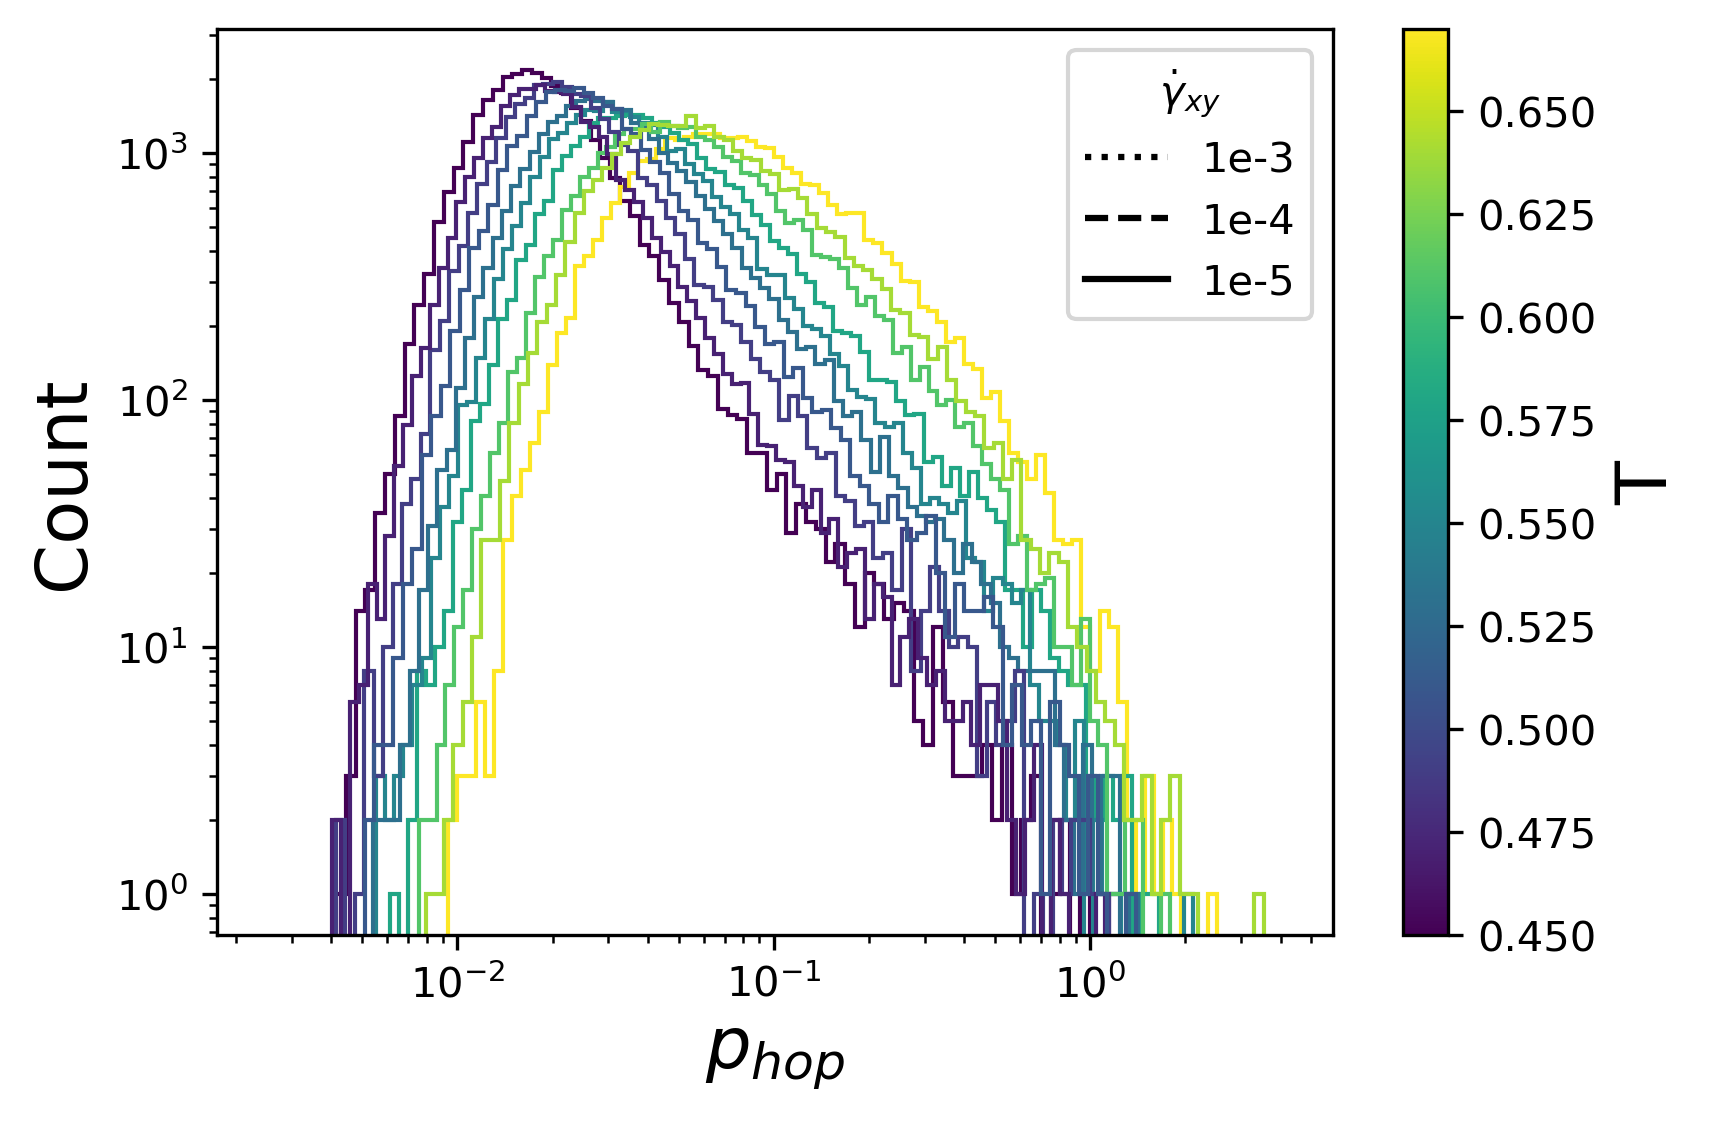

In [8]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/analysis_traj.gsd"))
    for run in runs[:10]:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/analysis_traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        # pos0 = traj[0].particles.position
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            # new = frame.particles.position
            image -= unit_box.get_images(new - prev)
            x = box.make_absolute(new)
            x = box.unwrap(x, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        phop = schmeud_dynamics.p_hop(np.array(pos), 11)
        # plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])
        plt.hist(phop[0], bins=np.geomspace(np.min(phop), np.max(phop), 100), histtype="step", color=cmap(norm(temp)), linestyle=ls[rate])
        # break
    break

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.xlabel(r'$p_{hop}$')
plt.ylabel("Count")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}_{xy}$")
plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0,

In [ ]:
cmap = cm.viridis
norm = colors.Normalize(vmin=0.45, vmax=0.67)

ls = {1e-3: ":", 1e-4: "--", 1e-5: "-"}

for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    # print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = glob.glob(job.fn("shear_runs/rate-*/temp-*/analysis_traj.gsd"))
    for run in runs:
        rate = float(utils.extract_between(run, "rate-", "/temp-"))
        temp = float(utils.extract_between(run, "temp-", "/analysis_traj.gsd"))
        # print(run)
        traj = gsd.hoomd.open(run, "rb")
        # msd = freud.msd.MSD(mode="window")
        pos = []
        time = []
        step0 = traj[0].configuration.step
        box0 = freud.box.Box.from_box(traj[0].configuration.box)
        pos0 = box0.make_fractional(traj[0].particles.position)
        unit_box = freud.box.Box.cube(1)
        cube_box = freud.box.Box.cube(box0.Lx)
        prev = pos0
        image = np.zeros((len(traj[0].particles.position), 3), dtype=np.int32)
        for frame in traj:
            box = freud.box.Box.from_box(frame.configuration.box)
            new = box.make_fractional(frame.particles.position)
            image += unit_box.get_images(new - prev)
            x = box.unwrap(new, image)
            x -= box.make_absolute(pos0)
            pos.append(x)
            time.append((frame.configuration.step - step0)*dt)
            prev = new
        print(len(pos))
        phop = schmeud_dynamics.nonaffine_local_strain()
        # plt.plot(time, pos, color=cmap(norm(temp)), linestyle=ls[rate])
        # plt.hist(phop)
        break
    break

lines = []
lines.append(plt.Line2D([0], [0], color="black", linestyle=":"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="--"))
lines.append(plt.Line2D([0], [0], color="black", linestyle="-"))

plt.ylabel(r"$\sigma_{xy}$")
plt.xlabel(r"$\gamma_{xy}$")
plt.legend(lines, ["1e-3", "1e-4", "1e-5"], title=r"$\dot{\gamma}_{xy}$")
# plt.yscale('log')
plt.xscale('log')
# plt.ylim(7e0, 1.5e2)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label="T")